# Table of Contents

* ### Import statements and load data
* ### Transform data
* ### Business question 1

    Which genre(s) are most successful?
    
* ### Business question 2

    What production budget is optimal for a successful movie in this genre?
    
* ### Business question 3

    What time of year do movies with the highest worldwide gross get released?
    
* ### Appendix

# Import Statements and Load Data

In [1]:
import pandas as pd
import numpy as np

import sqlite3

from pandasql import sqldf
psdf = lambda x: sqldf(x, globals())

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline

import json

In [2]:
conn = sqlite3.connect('Data/im.db')

query = ''' SELECT *
            FROM movie_basics
            JOIN movie_ratings
            USING(movie_id)
            ;'''

imdb_movies = pd.read_sql(query, conn)

imdb_movies.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [3]:
tn_movie_budgets = pd.read_csv('rawData/tn.movie_budgets.csv.gz', compression='gzip')

tn_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [4]:
bom_movie_gross = pd.read_csv('rawData/bom.movie_gross.csv.gz', compression='gzip')

bom_movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [5]:
kaggle_tmdb_5000 = pd.read_csv('rawData/tmdb_5000_movies.csv.zip')

kaggle_tmdb_5000.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


# Transform Data

In [6]:
def to_float(value):
    """Takes in a string or float. If string, removes up to 3 commas, 1 $ sign, and whitespace, then converts to float."""
    if type(value) == float:
        return value
    else:
        value = value.replace(',', '')
        value = value.replace(',', '')
        value = value.replace(',', '')
        value = value.replace('$', '')
        value = value.strip()
        return float(value)

#### Transform budget and revenue columns in tn_movie_budgets (to float)

In [7]:
tn_movie_budgets['production_budget'] = tn_movie_budgets['production_budget'].map(to_float)

In [8]:
tn_movie_budgets['domestic_gross'] = tn_movie_budgets['domestic_gross'].map(to_float)

In [9]:
tn_movie_budgets['worldwide_gross'] = tn_movie_budgets['worldwide_gross'].map(to_float)

#### Transform bom_movie_gross foreign_gross values (to float)

In [10]:
bom_movie_gross['foreign_gross'] = bom_movie_gross['foreign_gross'].map(to_float)

#### Drop one null value for release date in kaggle_tmdb_5000

In [11]:
kaggle_tmdb_5000.dropna(subset=['release_date'], inplace=True)

### Join all data into one table

#### Make a field called "movie_year" in all tables, to match records by film title and release year

In [12]:
imdb_movies['movie_year'] = imdb_movies['primary_title'] + ' ' + imdb_movies['start_year'].map(lambda x: str(x))

In [13]:
tn_movie_budgets['movie_year'] = tn_movie_budgets['movie'] + ' ' + tn_movie_budgets['release_date'].map(lambda x: x[-4:])

In [14]:
bom_movie_gross['movie_year'] = bom_movie_gross['title'] + ' ' + bom_movie_gross['year'].map(lambda x: str(x))

In [15]:
kaggle_tmdb_5000['movie_year'] = kaggle_tmdb_5000['original_title'] + ' ' +\
                                kaggle_tmdb_5000['release_date'].map(lambda x: str(x)[:4])

#### Use pandasql to join the tables on movie_year, and perform an inner join

In [16]:
query = ''' SELECT t.release_date, t.movie, t.production_budget, t.domestic_gross, t.worldwide_gross,
                    i.primary_title, i.start_year, i.runtime_minutes, i.genres AS imdb_genres,
                    k.genres AS tmdb_genres, k.keywords, k.original_title, k.overview, k.production_companies,
                    k.release_date AS tmdb_release_date, k.runtime AS tmdb_runtime, b.studio, t.movie_year
            FROM tn_movie_budgets as t
            LEFT JOIN imdb_movies as i
            ON i.movie_year = t.movie_year
            LEFT JOIN kaggle_tmdb_5000 as k
            ON i.movie_year = k.movie_year
            LEFT JOIN bom_movie_gross as b
            USING(movie_year)
            WHERE (k.budget IS NOT NULL) | (t.production_budget IS NOT NULL)
            ;
            '''

all_movies = psdf(query)

In [17]:
all_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5818 entries, 0 to 5817
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   release_date          5818 non-null   object 
 1   movie                 5818 non-null   object 
 2   production_budget     5818 non-null   float64
 3   domestic_gross        5818 non-null   float64
 4   worldwide_gross       5818 non-null   float64
 5   primary_title         1498 non-null   object 
 6   start_year            1498 non-null   float64
 7   runtime_minutes       1490 non-null   float64
 8   imdb_genres           1496 non-null   object 
 9   tmdb_genres           977 non-null    object 
 10  keywords              977 non-null    object 
 11  original_title        977 non-null    object 
 12  overview              976 non-null    object 
 13  production_companies  977 non-null    object 
 14  tmdb_release_date     977 non-null    object 
 15  tmdb_runtime         

### Aside: Which specific individual movies have the highest worldwide gross?

In [18]:
all_movies.loc[all_movies.worldwide_gross.sort_values(ascending=False)[:10].index]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,start_year,runtime_minutes,imdb_genres,tmdb_genres,keywords,original_title,overview,production_companies,tmdb_release_date,tmdb_runtime,studio,movie_year
0,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,None,NaN,NaN,None,None,None,None,None,None,None,NaN,None,Avatar 2009
42,"Dec 19, 1997",Titanic,200000000.0,659363944.0,2.208208e+09,None,NaN,NaN,None,None,None,None,None,None,None,NaN,None,Titanic 1997
5,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2.053311e+09,None,NaN,NaN,None,None,None,None,None,None,None,NaN,None,Star Wars Ep. VII: The Force Awakens 2015
6,"Apr 27, 2018",Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,Avengers: Infinity War,2018.0,149.0,"Action,Adventure,Sci-Fi",None,None,None,None,None,None,NaN,BV,Avengers: Infinity War 2018
33,"Jun 12, 2015",Jurassic World,215000000.0,652270625.0,1.648855e+09,Jurassic World,2015.0,124.0,"Action,Adventure,Sci-Fi","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1299, ""name"": ""monster""}, {""id"": 1718,...",Jurassic World,Twenty-two years after the events of Jurassic ...,"[{""name"": ""Universal Studios"", ""id"": 13}, {""na...",2015-06-09,124.0,Uni.,Jurassic World 2015
67,"Apr 3, 2015",Furious 7,190000000.0,353007020.0,1.518723e+09,Furious 7,2015.0,137.0,"Action,Crime,Thriller","[{""id"": 28, ""name"": ""Action""}]","[{""id"": 830, ""name"": ""car race""}, {""id"": 3428,...",Furious 7,Deckard Shaw seeks revenge against Dominic Tor...,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...",2015-04-01,137.0,Uni.,Furious 7 2015
26,"May 4, 2012",The Avengers,225000000.0,623279547.0,1.517936e+09,The Avengers,2012.0,143.0,"Action,Adventure,Sci-Fi","[{""id"": 878, ""name"": ""Science Fiction""}, {""id""...","[{""id"": 242, ""name"": ""new york""}, {""id"": 5539,...",The Avengers,When an unexpected enemy emerges and threatens...,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...",2012-04-25,143.0,None,The Avengers 2012
3,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,Avengers: Age of Ultron,2015.0,141.0,"Action,Adventure,Sci-Fi","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,"[{""name"": ""Marvel Studios"", ""id"": 420}, {""name...",2015-04-22,141.0,BV,Avengers: Age of Ultron 2015
41,"Feb 16, 2018",Black Panther,200000000.0,700059566.0,1.348258e+09,Black Panther,2018.0,134.0,"Action,Adventure,Sci-Fi",None,None,None,None,None,None,NaN,BV,Black Panther 2018
262,"Jul 15, 2011",Harry Potter and the Deathly Hallows: Part II,125000000.0,381193157.0,1.341693e+09,None,NaN,NaN,None,None,None,None,None,None,None,NaN,None,Harry Potter and the Deathly Hallows: Part II ...


## Business Question: What are the most successful genre(s)?
### Metric: Average Worldwide Gross

How does the average worldwide gross of a film vary (or fail to vary) according to genre?

### Additional Data Cleaning for Genre Analysis

In [19]:
# since tmdb_genres only adds info for one record, transfer that data to imdb_genres, drop tmdb_genres & rename imdb_genres
# as 'genres'
all_movies.loc[1278, 'imdb_genres'] = 'Action'

all_movies.drop(axis=1, labels='tmdb_genres', inplace=True)

all_movies.rename(columns={'imdb_genres':'genres'}, inplace=True)

In [20]:
# make a copy of movies for genre analysis, and drop records for which genre is null
movies_w_genres = all_movies.copy()

movies_w_genres.dropna(subset=['genres'], inplace=True)

In [25]:
len(movies_w_genres)

1497

### Group by Genres & Look at Mean Worldwide Gross

In [21]:
movies_w_genres.groupby('genres').mean()['worldwide_gross'].sort_values(ascending=False)

genres
Family,Fantasy,Musical     1.259200e+09
Fantasy,Musical            1.025491e+09
Adventure,Fantasy          7.012107e+08
Adventure,Drama,Sci-Fi     6.608254e+08
Action,Adventure,Sci-Fi    6.578237e+08
                               ...     
Family                     0.000000e+00
Action,Crime,Fantasy       0.000000e+00
Animation                  0.000000e+00
Comedy,Mystery,Thriller    0.000000e+00
Western                    0.000000e+00
Name: worldwide_gross, Length: 229, dtype: float64

I am surprised to see that "Family, Fantasy, Musical" is the highest average grossing genre. Are there enough movies of this genre in my sample to draw a conclusion about all films in this genre? I am going to filter my data to only include genres for which 30 or more films exist in my dataset.

#### Limit data to genres with at least 30 films in dataset

In [22]:
query = ''' SELECT genres, COUNT() AS num_films, AVG(worldwide_gross) AS avg_gross
            FROM movies_w_genres
            GROUP BY genres
            HAVING num_films >= 30
            ORDER BY avg_gross DESC
        ;
        '''

genres_atleast_30_films = psdf(query)

Base on this new criteria (at least 30 films in the dataset), I only have 12 genres for which enough data exists in my sample to draw conclusions about all films.

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


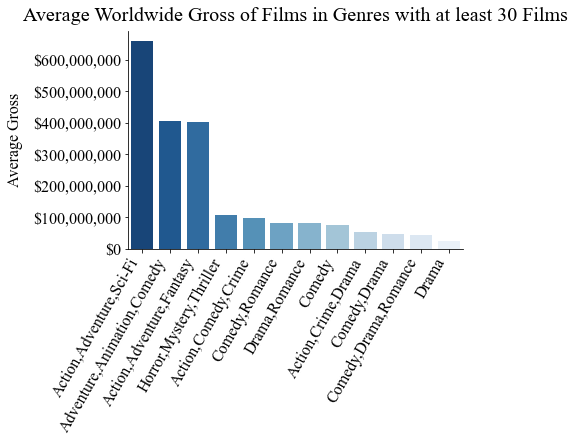

In [23]:
fig, ax = plt.subplots()

sns.barplot(genres_atleast_30_films['genres'], genres_atleast_30_films['avg_gross'], palette='Blues_r')

plt.xticks(rotation=60, ha='right')

ax.set_title('Average Worldwide Gross of Films in Genres with at least 30 Films', fontname= 'Times New Roman', fontsize=20, pad=10)

ax.set_xticklabels(genres_atleast_30_films['genres'], fontname='Times New Roman', fontsize=16)

ax.set_xlabel('')

ax.set_ylabel('Average Gross', fontname='Times New Roman', fontsize=16, labelpad=10)

[t.set_fontname('Times New Roman') for t in ax.yaxis.get_ticklabels()]

[t.set_fontsize(16) for t in ax.yaxis.get_ticklabels()]

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(gross_fmt)

fig.savefig('Images/avg_gross_all_genres', bbox_inches='tight');

#### We have 3 clear "winners" in terms of genre

The top 3 most successful genres out-gross the other genres by 4 fold or more, on average. I am going to display the top 3 most successful genres in my presentation.

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


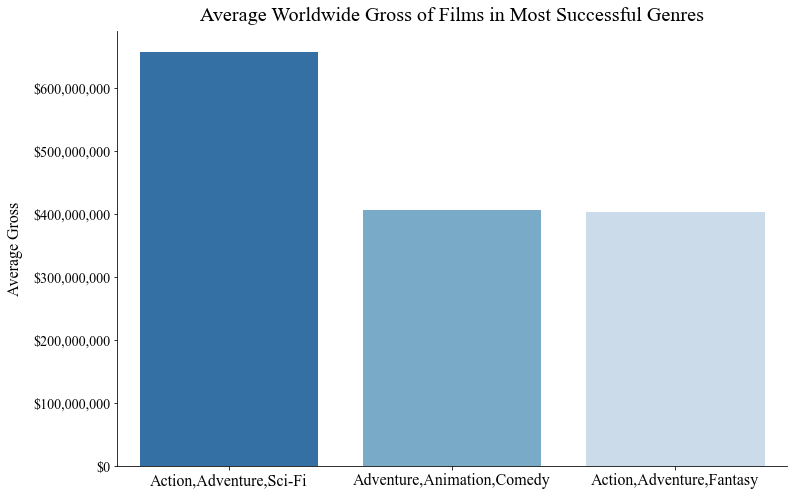

In [26]:
fig, ax = plt.subplots(figsize=(12,8))


sns.barplot(genres_atleast_30_films['genres'][:3], genres_atleast_30_films['avg_gross'][:3], ax=ax, palette='Blues_r')

ax.set_title('Average Worldwide Gross of Films in Most Successful Genres', fontname= 'Times New Roman', fontsize=20, pad=10)

ax.set_xticklabels(genres_atleast_30_films['genres'][:3], fontname='Times New Roman', fontsize=16)

ax.set_xlabel('')

ax.set_ylabel('Average Gross', fontname='Times New Roman', fontsize=16, labelpad=10)

[t.set_fontname('Times New Roman') for t in ax.yaxis.get_ticklabels()]
[t.set_fontsize(14) for t in ax.yaxis.get_ticklabels()]

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(gross_fmt);

Before I make any final conclusions about what to recommend, I want to dig into the distribution of worldwide gross for movies in each of these genres.

## Business Question 1.5.
### How successful are those top 3 genres?


Analyze the distribution of worldwide gross by genre, to ensure that the mean isn't be skewed by outliers. Are these genres truly a sure bet?

### 1.   Action Adventure Science Fiction

In [50]:
genre1_budget = movies_w_genres.loc[ movies_w_genres['genres'] == genres_atleast_30_films['genres'][0] ].loc\
[:,['movie', 'production_budget']]

In [53]:
genre1_budget.head()

,movie,production_budget
2,Dark Phoenix,350000000.0
3,Avengers: Age of Ultron,330600000.0
6,Avengers: Infinity War,300000000.0
13,John Carter,275000000.0
16,Captain America: Civil War,250000000.0


C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


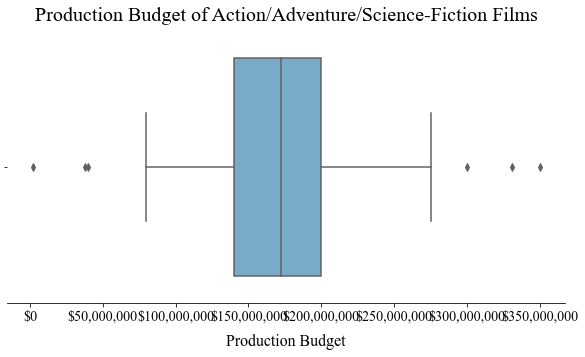

In [52]:
fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(genre1_budget['production_budget'], ax=ax, palette='Blues_r')

ax.set_title('Production Budget of Action/Adventure/Science-Fiction Films', fontsize=20, pad=10, fontname='Times New Roman')
ax.set_xlabel('Production Budget', fontsize=16, labelpad=10, fontname='Times New Roman')
[t.set_fontname('Times New Roman') for t in ax.xaxis.get_ticklabels() ]
[ t.set_fontsize(14) for t in ax.xaxis.get_ticklabels() ]

# don't show the axes spines
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)

gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.xaxis.set_major_formatter(gross_fmt)

fig.savefig('Images/top_genre_distribution', bbox_inches='tight');

#### Action Adventure Science-Fiction films / Distribution of Worldwide Gross

Create a new dataframe with only the titles and worldwide gross of Action/Adventure/Sci-Fi movies.

In [27]:
genre1_gross = movies_w_genres.loc[ movies_w_genres['genres'] == genres_atleast_30_films['genres'][0] ].loc\
[:,['movie', 'worldwide_gross']]

In [54]:
genre1_gross.loc[ genre1_gross['movie'] == 'Dark Phoenix']

,movie,worldwide_gross
2,Dark Phoenix,149762350.0


Create a box plot to analyze the distribution of worldwide gross for Action/Adventure/Sci-Fi movies.

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


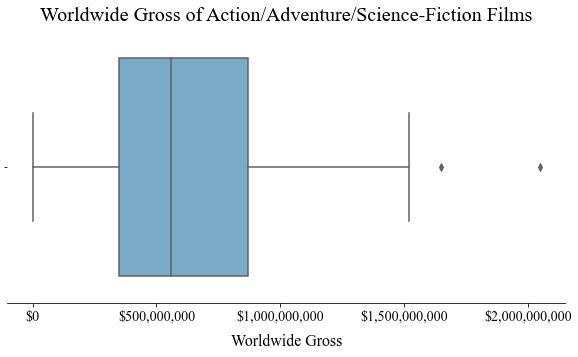

In [29]:
fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(genre1_gross['worldwide_gross'], ax=ax, palette='Blues_r')

ax.set_title('Worldwide Gross of Action/Adventure/Science-Fiction Films', fontsize=20, pad=10, fontname='Times New Roman')
ax.set_xlabel('Worldwide Gross', fontsize=16, labelpad=10, fontname='Times New Roman')
[t.set_fontname('Times New Roman') for t in ax.xaxis.get_ticklabels() ]
[ t.set_fontsize(14) for t in ax.xaxis.get_ticklabels() ]

# don't show the axes spines
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)

gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.xaxis.set_major_formatter(gross_fmt)

fig.savefig('Images/top_genre_distribution', bbox_inches='tight');

#### Action Adventure Science-Fiction films / Distribution of Worldwide Gross without Outliers

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


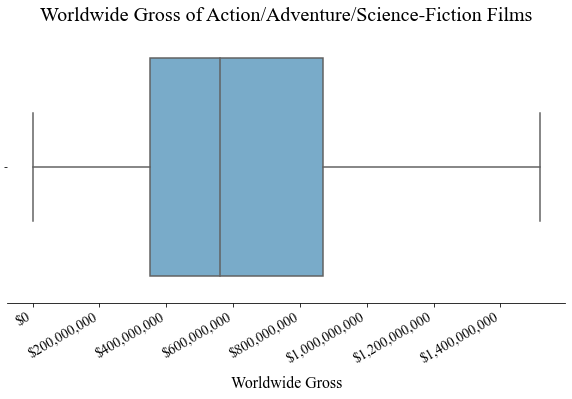

In [30]:
fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(genre1_gross['worldwide_gross'], ax=ax, palette='Blues_r', showfliers=False)

ax.set_title('Worldwide Gross of Action/Adventure/Science-Fiction Films', fontsize=20, pad=10, fontname='Times New Roman')
ax.set_xlabel('Worldwide Gross', fontsize=16, labelpad=10, fontname='Times New Roman')
[t.set_fontname('Times New Roman') for t in ax.xaxis.get_ticklabels() ]
[ t.set_fontsize(14) for t in ax.xaxis.get_ticklabels() ]

# don't show the axes spines
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)

gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.xaxis.set_major_formatter(gross_fmt)
plt.xticks(rotation=30, ha='right');

#### Action Adventure Science-Fiction films / Percentage that Break Even
Roughly 96% of films in this genre breakeven.

In [31]:
len( movies_w_genres.loc[ (movies_w_genres['genres'] == genres_atleast_30_films['genres'][0])\
                        & (movies_w_genres['worldwide_gross'] >= movies_w_genres['production_budget']) ] ) / \
len( movies_w_genres.loc[ (movies_w_genres['genres'] == genres_atleast_30_films['genres'][0]) ] )

0.9615384615384616

#### Action Adventure Science-Fiction films / Outliers
"Avengers: Infinity War" and "Jurassic World" are the outliers.

In [32]:
genre1_q1 = genre1_gross['worldwide_gross'].quantile(q=0.25)
genre1_q3 = genre1_gross['worldwide_gross'].quantile(q=0.75)
genre1_iqr = genre1_q3 - genre1_q1

# Find those outliers!
genre1_gross.loc[ genre1_gross['worldwide_gross'] >= genre1_q3 + 1.5*genre1_iqr ]

,movie,worldwide_gross
6,Avengers: Infinity War,2.048134e+09
33,Jurassic World,1.648855e+09


#### Action Adventure Science-Fiction films / Average Production Budget
The average production budget of a film in this genre is \\$173,161,530, or about $175 million.

In [33]:
genre1_budget = movies_w_genres.loc[ movies_w_genres['genres'] == genres_atleast_30_films['genres'][0] ].loc\
[:,['movie', 'production_budget']]

genre1_avg_budget = genre1_budget.mean().values[0]

print(f'The average production budget of a film in this genre is {round(genre1_avg_budget,0)}.')

The average production budget of a film in this genre is 173161538.0.


#### Action Adventure Science-Fiction films / Correlation between Production Budget and Worldwide Gross
There is a moderate positive correlation (~50%) between production budget and worldwide gross.

In [35]:
np.corrcoef(genre1_budget['production_budget'], genre1_gross['worldwide_gross'])[0][1]

0.4960438957902136

Create a scatter plot to explore the correlation visually.

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


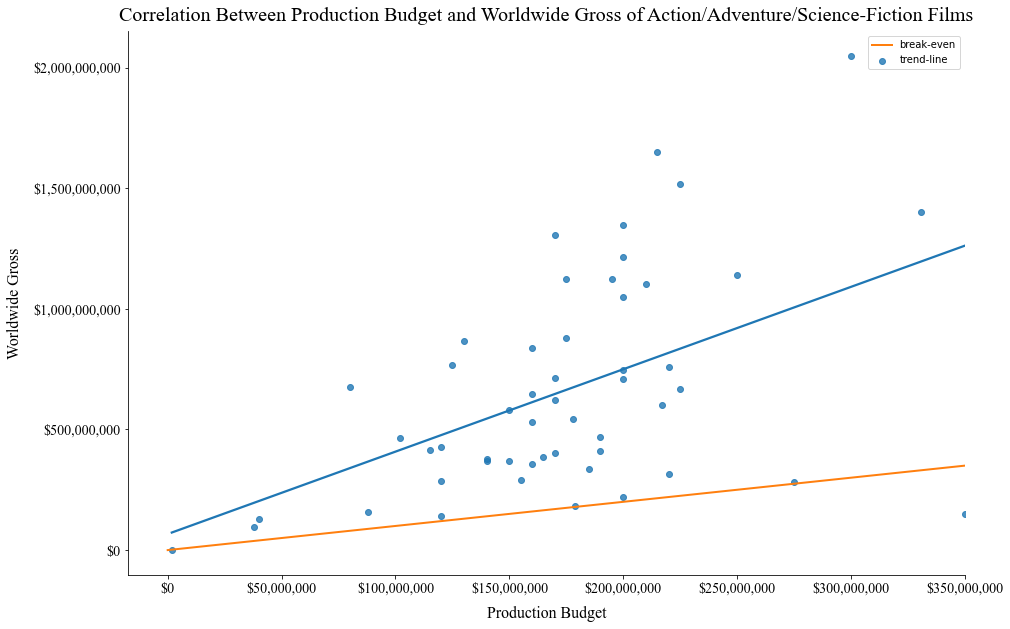

In [57]:
fig, ax = plt.subplots(figsize=(15,10))

x = np.linspace(0, 350000000, 1000000)
y = x

sns.regplot(genre1_budget['production_budget'], genre1_gross['worldwide_gross'], ax=ax, ci=None, label='trend-line')
ax.plot(x, y, linewidth=2, label='break-even')

ax.set_title('Correlation Between Production Budget and Worldwide Gross of Action/Adventure/Science-Fiction Films',\
             fontsize=20, pad=10, fontname='Times New Roman')
ax.set_xlabel('Production Budget', fontsize=16, labelpad=10, fontname='Times New Roman')
ax.set_ylabel('Worldwide Gross', fontsize=16, labelpad=10, fontname='Times New Roman')

gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.xaxis.set_major_formatter(gross_fmt)
ax.yaxis.set_major_formatter(gross_fmt)

[t.set_fontname('Times New Roman') for t in ax.yaxis.get_ticklabels()]
[t.set_fontsize(14) for t in ax.yaxis.get_ticklabels()]

[t.set_fontname('Times New Roman') for t in ax.xaxis.get_ticklabels()]
[t.set_fontsize(14) for t in ax.xaxis.get_ticklabels()]

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend()

fig.savefig('Images/correlation_production_budget_and_gross', bbox_inches='tight');

---

### 2.   Adventure Animation Comedy

#### Adventure Animation Comedy films / Distribution of Worldwide Gross

In [43]:
genre2_gross = movies_w_genres.loc[ movies_w_genres['genres'] == genres_atleast_30_films['genres'][1] ].loc\
[:,['movie', 'worldwide_gross']]

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


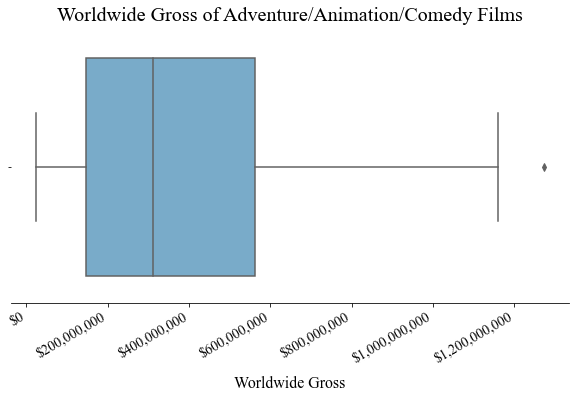

In [47]:
fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(genre2_gross['worldwide_gross'], ax=ax, palette='Blues_r')

ax.set_title('Worldwide Gross of Adventure/Animation/Comedy Films', fontsize=20, pad=10, fontname='Times New Roman')
ax.set_xlabel('Worldwide Gross', fontsize=16, labelpad=10, fontname='Times New Roman')
[t.set_fontname('Times New Roman') for t in ax.xaxis.get_ticklabels() ]
[ t.set_fontsize(14) for t in ax.xaxis.get_ticklabels() ]

# don't show the axes spines
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)

gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.xaxis.set_major_formatter(gross_fmt)

plt.xticks(rotation=30, ha='right');

#### Adventure Animation Comedy films / Percentage that Break Even
Roughly 97% of movies in this genre break even.

In [48]:
len( movies_w_genres.loc[ (movies_w_genres['genres'] == genres_atleast_30_films['genres'][1])\
                        & (movies_w_genres['worldwide_gross'] >= movies_w_genres['production_budget']) ] ) / \
len( movies_w_genres.loc[ (movies_w_genres['genres'] == genres_atleast_30_films['genres'][1]) ] )

0.9701492537313433

#### Adventure Animation Comedy films / Outlier
Frozen is the outlier.

In [49]:
genre2_q1 = genre2_gross['worldwide_gross'].quantile(q=0.25)
genre2_q3 = genre2_gross['worldwide_gross'].quantile(q=0.75)
genre2_iqr = genre2_q3 - genre2_q1

# Find those outliers!
genre2_gross.loc[ genre2_gross['worldwide_gross'] >= genre2_q3 + 1.5*genre2_iqr ]

,movie,worldwide_gross
157,Frozen,1.272470e+09


#### Adventure Animation Comedy films / Average Production Budget
The average production budget of a film in this genre is \\$102,768,657, or about $100 million.

In [50]:
genre2_budget = movies_w_genres.loc[ movies_w_genres['genres'] == genres_atleast_30_films['genres'][1] ].loc\
[:,['movie', 'production_budget']]

genre2_avg_budget = genre2_budget.mean().values[0]

print(f'The average production budget of a film in this genre is {round(genre2_avg_budget,0)}.')

The average production budget of a film in this genre is 102768657.0.


#### Adventure Animation Comedy films / Correlation between Production Budget and Worldwide Gross
There is a moderate, but not strong, positive correlation (~57%) between production budget and worldwide gross.

In [51]:
np.corrcoef(genre2_budget['production_budget'], genre2_gross['worldwide_gross'])[0][1]

0.570428124551779

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


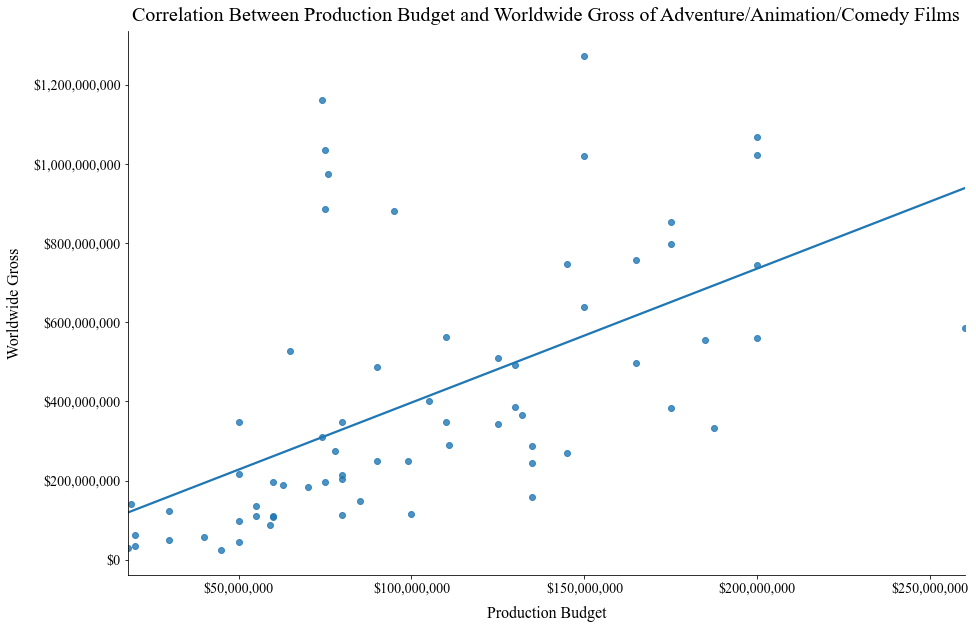

In [53]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.regplot(genre2_budget['production_budget'], genre2_gross['worldwide_gross'], ax=ax, ci=False)

ax.set_title('Correlation Between Production Budget and Worldwide Gross of Adventure/Animation/Comedy Films',\
             fontsize=20, pad=10, fontname='Times New Roman')
ax.set_xlabel('Production Budget', fontsize=16, labelpad=10, fontname='Times New Roman')
ax.set_ylabel('Worldwide Gross', fontsize=16, labelpad=10, fontname='Times New Roman')

gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.xaxis.set_major_formatter(gross_fmt)
ax.yaxis.set_major_formatter(gross_fmt)

[t.set_fontname('Times New Roman') for t in ax.yaxis.get_ticklabels()]
[t.set_fontsize(14) for t in ax.yaxis.get_ticklabels()]

[t.set_fontname('Times New Roman') for t in ax.xaxis.get_ticklabels()]
[t.set_fontsize(14) for t in ax.xaxis.get_ticklabels()]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

---

### 3.   Action Adventure Fantasy

#### Action Adventure Fantasy films / Distribution of Worldwide Gross

In [54]:
genre3_gross = movies_w_genres.loc[ movies_w_genres['genres'] == genres_atleast_30_films['genres'][2] ].loc\
[:,['movie', 'worldwide_gross']]

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


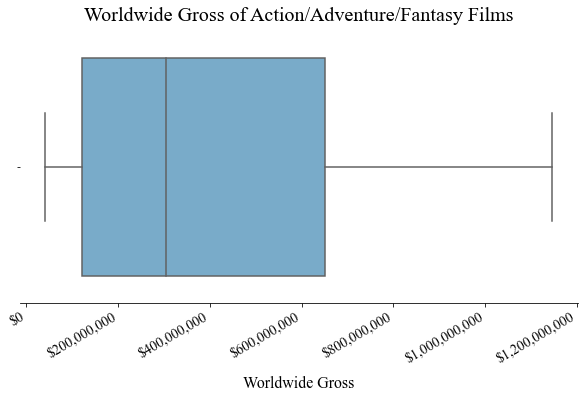

In [57]:
fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(genre3_gross['worldwide_gross'], ax=ax, palette='Blues_r')

ax.set_title('Worldwide Gross of Action/Adventure/Fantasy Films', fontsize=20, pad=10, fontname='Times New Roman')
ax.set_xlabel('Worldwide Gross', fontsize=16, labelpad=10, fontname='Times New Roman')
[t.set_fontname('Times New Roman') for t in ax.xaxis.get_ticklabels()]
[t.set_fontsize(14) for t in ax.xaxis.get_ticklabels()]

# don't show the axes spines
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)

gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.xaxis.set_major_formatter(gross_fmt)
plt.xticks(rotation=30, ha='right');

#### Action Adventure Fantasy / Percentage that Break Even
Roughly 97% of films in this genre break even.

In [58]:
len( movies_w_genres.loc[ (movies_w_genres['genres'] == genres_atleast_30_films['genres'][1])\
                        & (movies_w_genres['worldwide_gross'] >= movies_w_genres['production_budget']) ] ) / \
len( movies_w_genres.loc[ (movies_w_genres['genres'] == genres_atleast_30_films['genres'][1]) ] )

0.9701492537313433

#### Action Adventure Fantasy / Average Production Budget
The average production budget of a film in this genre is \\$149,858,065, or about $150 million.

In [61]:
genre3_budget = movies_w_genres.loc[ movies_w_genres['genres'] == genres_atleast_30_films['genres'][2] ].loc\
[:,['movie', 'production_budget']]

genre3_avg_budget = genre3_budget.mean().values[0]

print(f'The average production budget of a film in this genre is {round(genre3_avg_budget,0)}.')

The average production budget of a film in this genre is 149858065.0.


#### Action Adventure Fantasy / Correlation between Production Budget and Worldwide Gross
The correlation between production budget and worldwide gross is strong, at about 72%.

In [62]:
np.corrcoef(genre3_budget['production_budget'], genre3_gross['worldwide_gross'])[0][1]

0.7228559421966103

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


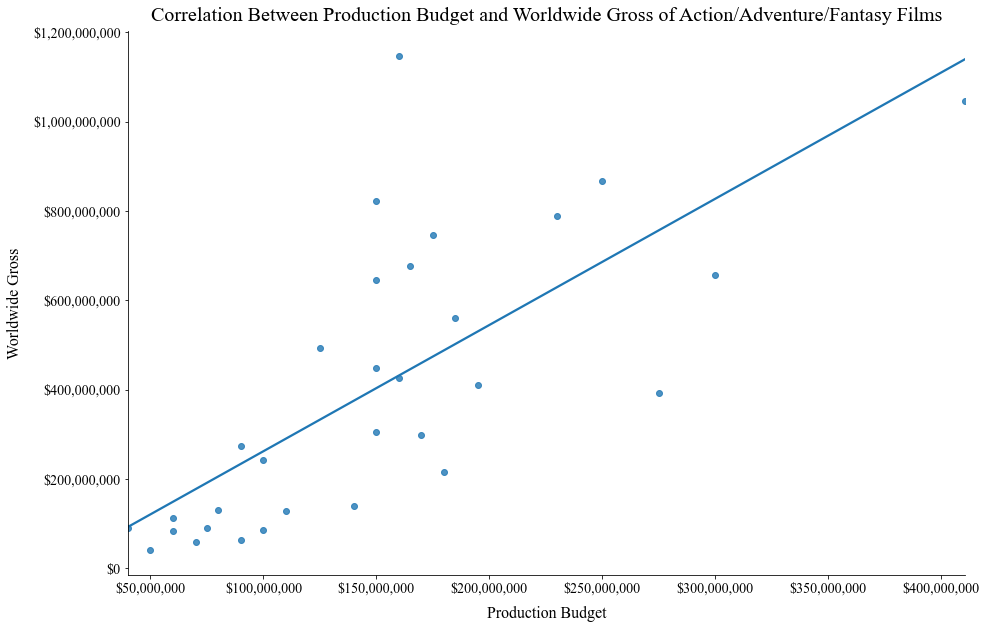

In [63]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.regplot(genre3_budget['production_budget'], genre3_gross['worldwide_gross'], ax=ax, ci=None)

ax.set_title('Correlation Between Production Budget and Worldwide Gross of Action/Adventure/Fantasy Films',\
             fontsize=20, pad=10, fontname='Times New Roman')
ax.set_xlabel('Production Budget', fontsize=16, labelpad=10, fontname='Times New Roman')
ax.set_ylabel('Worldwide Gross', fontsize=16, labelpad=10, fontname='Times New Roman')

gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.xaxis.set_major_formatter(gross_fmt)
ax.yaxis.set_major_formatter(gross_fmt)

[t.set_fontname('Times New Roman') for t in ax.yaxis.get_ticklabels()]
[t.set_fontsize(14) for t in ax.yaxis.get_ticklabels()]

[t.set_fontname('Times New Roman') for t in ax.xaxis.get_ticklabels()]
[t.set_fontsize(14) for t in ax.xaxis.get_ticklabels()]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

## Business Question: Which release date(s) generate the most revenue?
### Metric: Average Worldwide Gross, Total Worldwide Gross

How does the average worldwide gross of a film vary (or fail to vary) according to release date?

### Methodology
I want to go beyond the month of release and look at three "bands" per month: early in the month, middle of the month and late in the month.

These bands are *granular* enough to provide precise guidance on when to release a movie -- but still *broad* enough to ensure that at least one weekend per month falls into each category, regardless of calendar variations from year to year.

### Additional Data Cleaning for Release Date Analysis
Release dates in the following days of the month correspond to the given release "bands":

| Release Band | Days of Month |
| ------------ | ------------- |
| early-month  |    1-10       |
|  mid-month   |    11-21      |
| late-month   |    22-end     |

In [40]:
movie_dates = all_movies.copy()

movie_dates['release_month'] = movie_dates.release_date.map(lambda x: x[:3])

def part_of_month(value):
    ''' Decide, based on date as string, whether date is early, mid or late in the month.'''
    if int(value[4:6].replace(',','')) < 11:
        return 'early'
    elif int(value[4:6].replace(',','')) < 22:
        return 'mid'
    else:
        return 'late'
    
movie_dates['release_category'] = movie_dates['release_date'].map(part_of_month) +'-' + movie_dates.release_month

In [41]:
movie_dates.head(3)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,start_year,runtime_minutes,genres,keywords,original_title,overview,production_companies,tmdb_release_date,tmdb_runtime,studio,movie_year,release_month,release_category
0,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,None,NaN,NaN,None,None,None,None,None,None,NaN,None,Avatar 2009,Dec,mid-Dec
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,Pirates of the Caribbean: On Stranger Tides,2011.0,136.0,"Action,Adventure,Fantasy","[{""id"": 658, ""name"": ""sea""}, {""id"": 1316, ""nam...",Pirates of the Caribbean: On Stranger Tides,Captain Jack Sparrow crosses paths with a woma...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",2011-05-14,136.0,BV,Pirates of the Caribbean: On Stranger Tides 2011,May,mid-May
2,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,Dark Phoenix,2019.0,113.0,"Action,Adventure,Sci-Fi",None,None,None,None,None,NaN,None,Dark Phoenix 2019,Jun,early-Jun


First, let's check - are there any times of year that less than 30 movies are released? These release bands should be excluded from our analysis, because we don't have a large enough sample of these types of movies to draw valid conclusions about the population.

In [42]:
query = ''' SELECT release_category
            FROM movie_dates
            GROUP BY release_category
            HAVING COUNT() < 30
            ;
            '''

psdf(query)

,release_category


### Group by Release Categories & Look at Mean Worldwide Gross

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


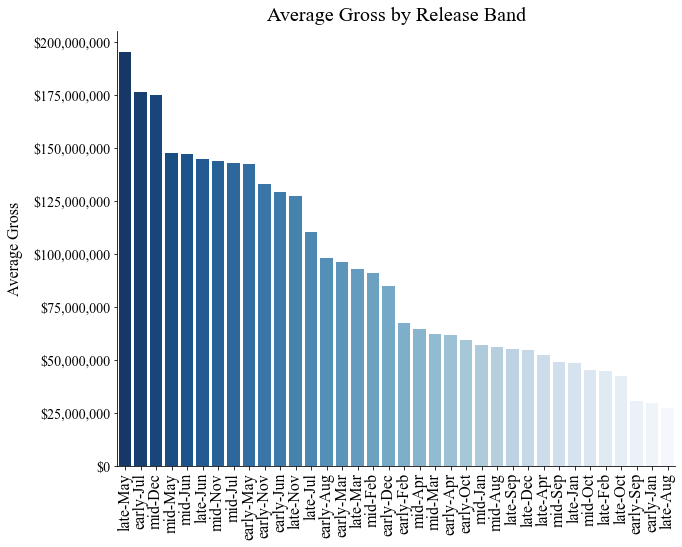

In [44]:
releaseband_avg_gross = movie_dates.groupby('release_category').mean()['worldwide_gross'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,8))

sns.barplot(releaseband_avg_gross.index, releaseband_avg_gross, ax=ax, palette='Blues_r')

ax.set_title('Average Gross by Release Band', fontname= 'Times New Roman', fontsize=20, pad=10)
ax.set_xticklabels(releaseband_avg_gross.index, fontname='Times New Roman', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Average Gross', fontname='Times New Roman', fontsize=16, labelpad=10)
[t.set_fontname('Times New Roman') for t in ax.yaxis.get_ticklabels()]
[t.set_fontsize(14) for t in ax.yaxis.get_ticklabels()]

# make y-axis numbers more readable
gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(gross_fmt)

plt.xticks(rotation=90)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('Images/avg_gross_by_release.png', bbox_inches='tight');

#### Again, there is a clear  "top 3"

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


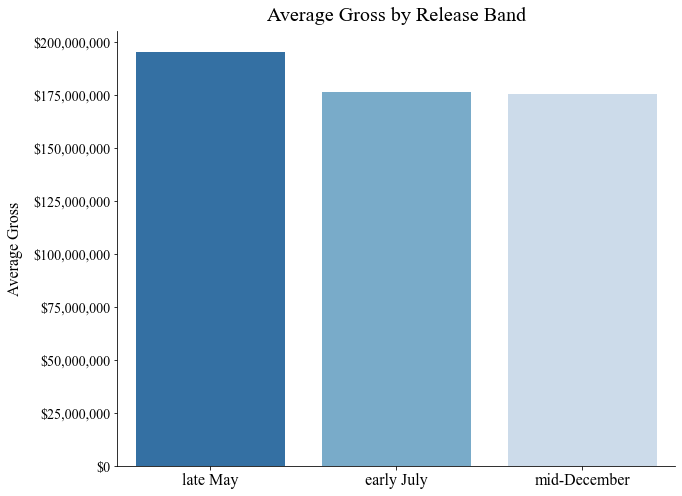

In [70]:
releaseband_avg_gross_top3 = movie_dates.groupby('release_category').mean()['worldwide_gross'].sort_values(ascending=False)\
[:3]

fig, ax = plt.subplots(figsize=(10,8))

sns.barplot(releaseband_avg_gross_top3.index, releaseband_avg_gross_top3, palette='Blues_r', ax=ax)

ax.set_title('Average Gross by Release Band', fontname= 'Times New Roman', fontsize=20, pad=10)
ax.set_xticklabels(['late May', 'early July', 'mid-December'], fontname='Times New Roman', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Average Gross', fontname='Times New Roman', fontsize=16, labelpad=10)
[t.set_fontname('Times New Roman') for t in ax.yaxis.get_ticklabels()]
[t.set_fontsize(14) for t in ax.yaxis.get_ticklabels()]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# make y-axis numbers more readable
gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(gross_fmt);

---


## Appendix

<ipython-input-49-938dc87ff74f>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = data.index, fontname='Times New Roman')


''

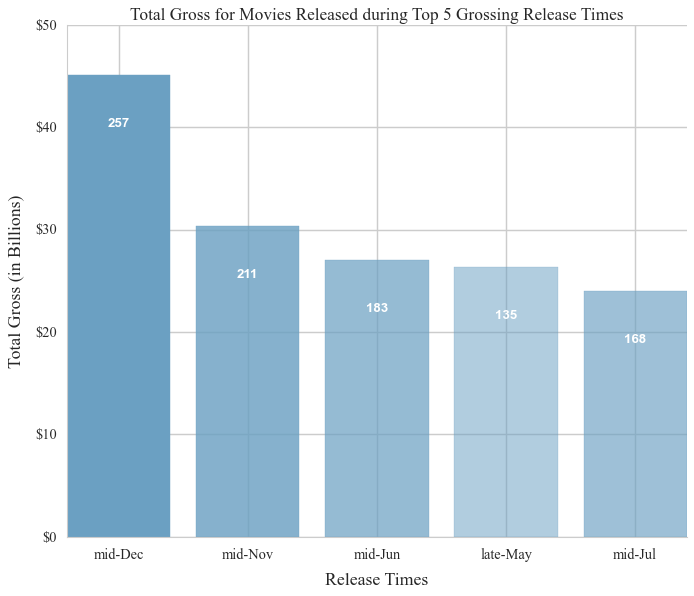

In [49]:
data = movie_dates.groupby('release_category').sum()['worldwide_gross'].sort_values(ascending=False)[:5]

style.use('seaborn-talk')
style.use('seaborn-whitegrid')

fig, ax = plt.subplots(figsize=(10,8))

num_movies = [ movie_dates['release_category'].value_counts()[category] for category in data.index ]

bars = ax.bar(data.index, data/1000000000)

# labels
ax.set_title(label='Total Gross for Movies Released during Top 5 Grossing Release Times', fontname='Times New Roman')

ax.set_xlabel('Release Times', fontname='Times New Roman', fontsize=16, labelpad=10)
ax.set_ylabel('Total Gross (in Billions)', fontname='Times New Roman', fontsize=16, labelpad=10)

ax.set_xticklabels(labels = data.index, fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set opacity of each bar to correspond to number of movies released in that category (in our dataset)
for i in range(len(num_movies)):
    bars[i].set_color((107/255, 160/255, 194/255, num_movies[i]/max(num_movies)))

# # set x- and y- axis colors to match fully opaque bar
# ax.spines['left'].set_color((0.6,0.1,0.8, 1))
# ax.spines['bottom'].set_color((0.6,0.1,0.8, 1))

# make y-axis numbers more readable
gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(gross_fmt)

# experiment with positioning text more precisely
i = 0
for b in bars:
    # width and height of bar b
    w,h = b.get_width(), b.get_height()
    # lower left vertex
    x0, y0 = b.xy
# annotate with number of movies 0.1 below midpoint of top of bar
    ax.annotate(f'{num_movies[i]}', xy=(0,0), xytext=(x0+w/2-0.085,y0+h-5), color='w', weight='bold')
    i+=1
    
fig.savefig('release-dates-bar.png', bbox_inches='tight')
;

### Production Companies

In [45]:
# Make a copy of all movies, transform production companies column from string-ified json to list of production company
# names, and drop any null values for production companies (given, or resulting from column transformation)

movies_w_production_companies = all_movies.copy() # copy dataframe for production company analysis

movies_w_production_companies.dropna(subset=['production_companies'], inplace=True) # drop record with null production comp

def to_list(value):
    '''Change string version of empty list to none, and otherwise, create a list of names of production companies'''
    if value == '[]':
        return None
    else:
        return [ pc_dict['name'] for pc_dict in json.loads(value) ]
    
movies_w_production_companies['production_companies'] = movies_w_production_companies['production_companies'].map(to_list)

movies_w_production_companies.dropna(subset=['production_companies'], inplace=True) # drop new null values

- Briefly explore, how many production companies are generally employed to work on a single film?

In [46]:
movies_w_production_companies.production_companies.map(len).value_counts() # most movies have 5 or less pcs

3     193
4     174
2     167
1     155
5      99
6      64
7      39
8      17
9      10
11      6
10      4
19      1
17      1
15      1
Name: production_companies, dtype: int64

In [47]:
movies_w_production_companies.production_companies.map(len).mean()

3.543501611170784

Most movies are produced by a group of 5 or less production companies. On the flip side, most films are produced by a group of production companies rather than a solo production company.

In [49]:
# Add some features to the data

movies_w_production_companies['profit'] = movies_w_production_companies['worldwide_gross']\
                                            - movies_w_production_companies['production_budget']

movies_w_production_companies['roi'] = movies_w_production_companies['profit']\
                                        / movies_w_production_companies['worldwide_gross']

movies_w_production_companies['percentage_of_revenue'] = movies_w_production_companies['worldwide_gross']\
/ movies_w_production_companies['production_companies'].map(len)\
/ movies_w_production_companies['worldwide_gross'].sum()

In [50]:
# create a new dataframe with one record for each unique movie-production company pair

all_records = []

for index in list(movies_w_production_companies.index):
    # copy record with this index
    current_slice = movies_w_production_companies.loc[index].copy()

    # get a list of production companies for this record
    companies = [ company for company in current_slice['production_companies'] ]

    # how many companies
    n = len(companies)

    # get a copy of the record for each company
    new_records = pd.DataFrame([current_slice]*n).copy()

    # reset production_companies column to have one company per row
    new_records['production_companies'] = companies

    # append your dataframe to the list of dataframes with all records
    all_records.append(new_records)

# concatenate all dataframes!
movies_by_production_companies = pd.concat(all_records).reset_index(drop=True)

#### Start experiment

In [51]:
query = ''' SELECT production_companies, SUM(percentage_of_revenue) AS mkt_share, COUNT() AS num_films
            FROM movies_by_production_companies
            GROUP BY production_companies
            ORDER BY num_films
            ;
            '''

distribution = psdf(query)

In [52]:
distribution.head(1)

,production_companies,mkt_share,num_films
0,10 West Studios,0.000025,1


68% of production companies in our dataset have produced only one film. 90% of production companies in our data set have produced 4 or less films.

In [53]:
distribution['num_films'].value_counts().map(lambda x: x/len(distribution)).cumsum()

1     0.682995
2     0.829951
3     0.876137
4     0.909727
5     0.926522
6     0.941218
7     0.952414
10    0.960112
8     0.966410
9     0.971309
11    0.975507
13    0.979006
12    0.982505
15    0.985304
17    0.986704
14    0.988104
22    0.989503
29    0.990903
32    0.992302
59    0.993002
18    0.993702
20    0.994402
21    0.995101
25    0.995801
27    0.996501
39    0.997201
46    0.997901
47    0.998600
56    0.999300
73    1.000000
Name: num_films, dtype: float64

In [54]:
len(distribution) - len(distribution['mkt_share'].loc[ distribution['mkt_share'] < 0.001 ])

185

In [55]:
movies_by_production_companies.groupby('production_companies').mean()['worldwide_gross'].sort_values(ascending=False)

production_companies
Québec Production Services Tax Credit          1.518723e+09
Abu Dhabi Film Commission                      1.518723e+09
Colorado Office of Film, Television & Media    1.518723e+09
Prime Focus                                    1.403014e+09
Deluxe Digital Studios                         1.140069e+09
                                                   ...     
Premiere Entertainment Group                   0.000000e+00
Parkside Pictures                              0.000000e+00
Culmination Productions                        0.000000e+00
North by Northwest Entertainment               0.000000e+00
Quite Quick Productions                        0.000000e+00
Name: worldwide_gross, Length: 1429, dtype: float64

In [56]:
movies_by_production_companies.loc[ movies_by_production_companies.production_companies == 'Québec Production Services Tax Credit' ]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,start_year,runtime_minutes,genres,keywords,original_title,overview,production_companies,tmdb_release_date,tmdb_runtime,studio,movie_year,profit,roi,percentage_of_revenue
130,"Apr 3, 2015",Furious 7,190000000.0,353007020.0,1.518723e+09,Furious 7,2015.0,137.0,"Action,Crime,Thriller","[{""id"": 830, ""name"": ""car race""}, {""id"": 3428,...",Furious 7,Deckard Shaw seeks revenge against Dominic Tor...,Québec Production Services Tax Credit,2015-04-01,137.0,Uni.,Furious 7 2015,1.328723e+09,0.874895,0.001067


In [57]:
movies_by_production_companies.loc[ movies_by_production_companies.production_companies == 'Abu Dhabi Film Commission' ]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,start_year,runtime_minutes,genres,keywords,original_title,overview,production_companies,tmdb_release_date,tmdb_runtime,studio,movie_year,profit,roi,percentage_of_revenue
132,"Apr 3, 2015",Furious 7,190000000.0,353007020.0,1.518723e+09,Furious 7,2015.0,137.0,"Action,Crime,Thriller","[{""id"": 830, ""name"": ""car race""}, {""id"": 3428,...",Furious 7,Deckard Shaw seeks revenge against Dominic Tor...,Abu Dhabi Film Commission,2015-04-01,137.0,Uni.,Furious 7 2015,1.328723e+09,0.874895,0.001067


In [58]:
movies_by_production_companies.loc[ movies_by_production_companies.production_companies == 'Colorado Office of Film, Television & Media' ]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,start_year,runtime_minutes,genres,keywords,original_title,overview,production_companies,tmdb_release_date,tmdb_runtime,studio,movie_year,profit,roi,percentage_of_revenue
133,"Apr 3, 2015",Furious 7,190000000.0,353007020.0,1.518723e+09,Furious 7,2015.0,137.0,"Action,Crime,Thriller","[{""id"": 830, ""name"": ""car race""}, {""id"": 3428,...",Furious 7,Deckard Shaw seeks revenge against Dominic Tor...,"Colorado Office of Film, Television & Media",2015-04-01,137.0,Uni.,Furious 7 2015,1.328723e+09,0.874895,0.001067


In [59]:
movies_by_production_companies.loc[ movies_by_production_companies.production_companies == 'Prime Focus' ]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,start_year,runtime_minutes,genres,keywords,original_title,overview,production_companies,tmdb_release_date,tmdb_runtime,studio,movie_year,profit,roi,percentage_of_revenue
4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,Avengers: Age of Ultron,2015.0,141.0,"Action,Adventure,Sci-Fi","[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,Prime Focus,2015-04-22,141.0,BV,Avengers: Age of Ultron 2015,1.072414e+09,0.764364,0.003284


In [60]:
movies_by_production_companies.loc[ movies_by_production_companies.production_companies == 'Deluxe Digital Studios' ]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,start_year,runtime_minutes,genres,keywords,original_title,overview,production_companies,tmdb_release_date,tmdb_runtime,studio,movie_year,profit,roi,percentage_of_revenue
26,"May 6, 2016",Captain America: Civil War,250000000.0,408084349.0,1.140069e+09,Captain America: Civil War,2016.0,147.0,"Action,Adventure,Sci-Fi","[{""id"": 393, ""name"": ""civil war""}, {""id"": 6091...",Captain America: Civil War,"Following the events of Age of Ultron, the col...",Deluxe Digital Studios,2016-04-27,147.0,BV,Captain America: Civil War 2016,890069413.0,0.780715,0.001601


In [61]:
movies_by_production_companies.groupby('production_companies').sum()['worldwide_gross'].sort_values(ascending=False)

production_companies
Universal Pictures              1.562323e+10
Warner Bros.                    1.499379e+10
Walt Disney Pictures            1.432401e+10
Columbia Pictures               1.386557e+10
Paramount Pictures              1.310682e+10
                                    ...     
Quite Quick Productions         0.000000e+00
Independence Day Productions    0.000000e+00
Rainsworth Productions          0.000000e+00
Rapid Heart Pictures            0.000000e+00
Seabourne Pictures              0.000000e+00
Name: worldwide_gross, Length: 1429, dtype: float64

#### End experiment

- Find production companies with over 1% of the revenue generated by films. These 16 companies have 35% of the "market share".

In [74]:
grouped_by_pc = movies_by_production_companies.groupby('production_companies').sum()
print(f'''{len(grouped_by_pc.loc[ grouped_by_pc['percentage_of_revenue'] > 0.01, 'percentage_of_revenue' ])} \
production companies generated \
{grouped_by_pc.loc[ grouped_by_pc['percentage_of_revenue'] > 0.01, 'percentage_of_revenue' ].sum()*100}% \
of the revenue.''')

16 production companies generated 35.68774073313781% of the revenue.


C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-128-228996fd5d6d>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x/1000000000) for x in current_values])


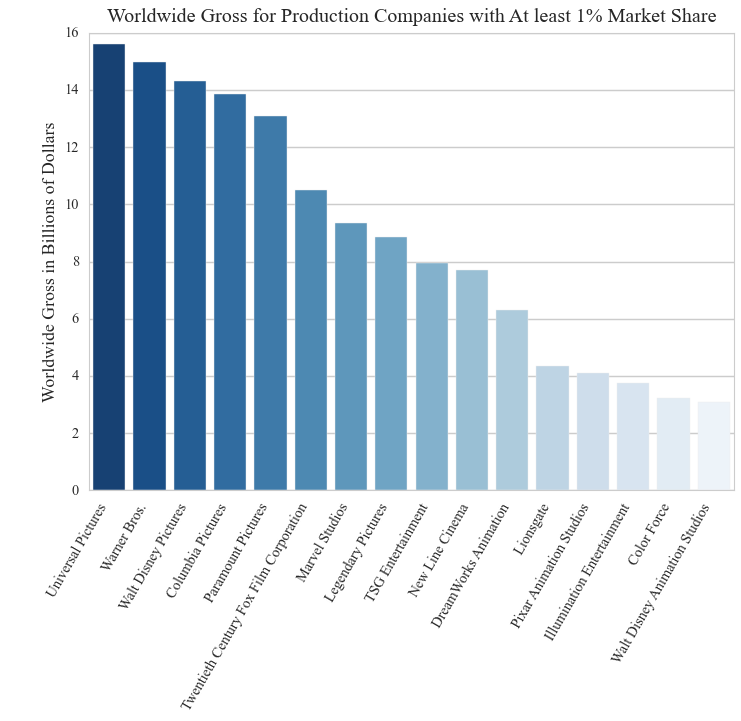

In [128]:
# grab the cumulative gross earned by production companies with at least 1% of the "market share" in film-making worldwide
top_pcs_total_gross = grouped_by_pc.loc[ grouped_by_pc['percentage_of_revenue'] > 0.01, 'worldwide_gross' ].\
                    sort_values(ascending=False)

# get labels
centered_labels = [ word.rjust(max(top_pcs_total_gross.index.map(len))) for word in top_pcs_total_gross.index ]

#plot a bar chart of total gross earned by these "top" production companies
fig, ax = plt.subplots()

style.use('seaborn-talk')
style.use('seaborn-whitegrid')

sns.barplot(top_pcs_total_gross.index, top_pcs_total_gross, palette='Blues_r')
ax.set_title('Worldwide Gross for Production Companies with At least 1% Market Share', fontname='Times New Roman',\
            fontsize=18, pad=10)
ax.set_ylabel(ylabel='Worldwide Gross in Billions of Dollars', fontsize=16, fontname='Times New Roman')
ax.set_xlabel(xlabel='', fontsize=16, fontname='Times New Roman')
ax.set_xticklabels(centered_labels, fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')

# fix y-ticklabels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x/1000000000) for x in current_values])

plt.xticks(rotation=60, ha='right')

fig.savefig('top-production-companies-by-market-share.png', bbox_inches='tight');

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-129-9697afacfb06>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x/1000000) for x in current_values], fontname='Times New Roman')


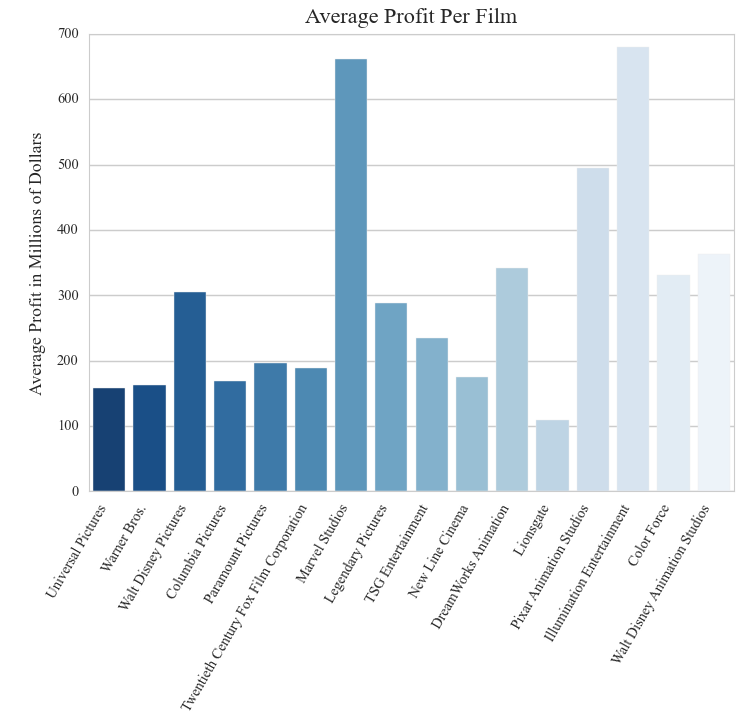

In [129]:
# not included in presentation

data2 = movies_by_production_companies.groupby('production_companies').mean().loc[top_pcs_total_gross.index]['profit']

fig, ax = plt.subplots()

style.use('seaborn-talk')
style.use('seaborn-whitegrid')

sns.barplot(data2.index, data2, palette='Blues_r')
ax.set_title('Average Profit Per Film', fontname='Times New Roman', fontsize=20, pad=10)
ax.set_ylabel(ylabel='Average Profit in Millions of Dollars', fontsize=16, fontname='Times New Roman',labelpad=10)
ax.set_xlabel(xlabel='', fontsize=16, fontname='Times New Roman')
ax.set_xticklabels(centered_labels, fontname='Times New Roman')

# fix y-ticklabels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x/1000000) for x in current_values], fontname='Times New Roman')

plt.xticks(rotation=60, ha='right')

fig.savefig('top-production-companies-by-market-share-avg-profit.png', bbox_inches='tight');

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


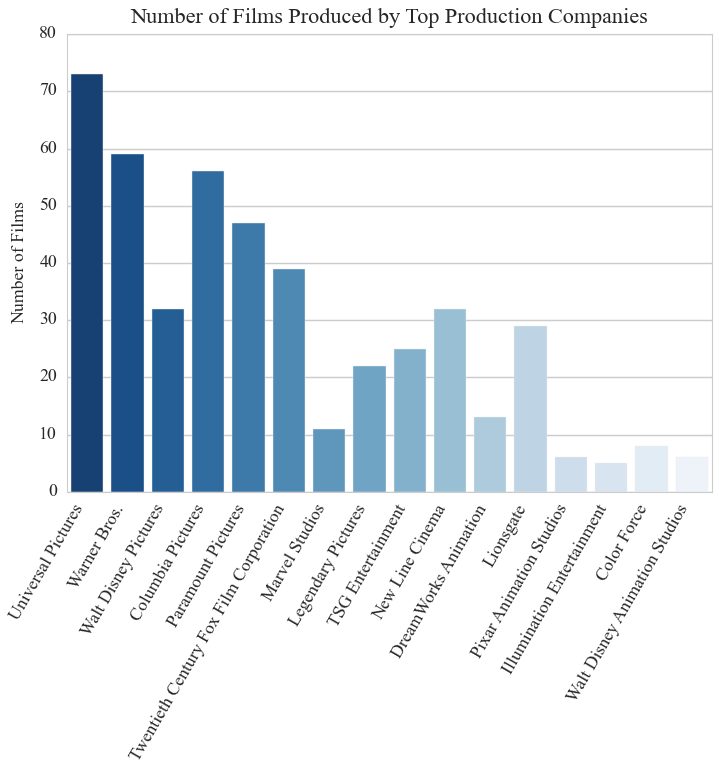

In [142]:
# not included in presentation

heights = [len(movies_by_production_companies.loc[movies_by_production_companies.production_companies==movie])\
 for movie in list(top_pcs_total_gross.index)]

style.use('seaborn-talk')
style.use('seaborn-whitegrid')

fig, ax = plt.subplots()

sns.barplot(top_pcs_total_gross.index, heights, palette='Blues_r')

ax.set_title('Number of Films Produced by Top Production Companies', fontname='Times New Roman', fontsize=20, pad=10)
ax.set_ylabel('Number of Films', fontname='Times New Roman', fontsize=16, labelpad=10)
ax.set_xticklabels(top_pcs_total_gross.index, fontname='Times New Roman', fontsize=16)
ax.set_xlabel('')

plt.xticks(rotation=60, ha='right')
plt.yticks(fontname='Times New Roman', fontsize=16)

fig.savefig('num_films_produced.png', bbox_inches='tight');

In [149]:
query = ''' SELECT production_companies
            FROM movies_by_production_companies
            GROUP BY production_companies
            HAVING (COUNT() >= 15) AND (AVG(profit) > 300000000)
            '''

psdf(query)

,production_companies
0,Walt Disney Pictures


In [87]:
len(movies_by_production_companies.groupby('production_companies'))

1429

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-109-b98d4b502582>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x/1000000000) for x in current_values], fontname='Times New Roman')


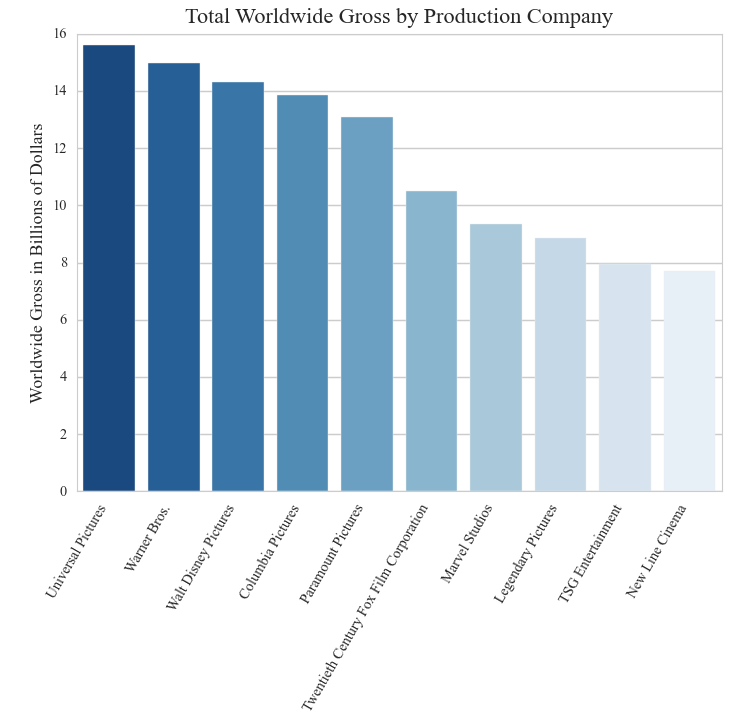

In [109]:
# grab the cumulative gross earned by production companies
data=movies_by_production_companies.groupby('production_companies').sum().worldwide_gross.sort_values(ascending=False)[:10]

# get labels
centered_labels = [ word.rjust(max(data.index.map(len))) for word in data.index ]

# plot a bar chart of total gross earned by these "top" production companies
fig, ax = plt.subplots()

style.use('seaborn-talk')
style.use('seaborn-whitegrid')

sns.barplot(data.index, data, palette='Blues_r')
ax.set_title('Total Worldwide Gross by Production Company', fontname='Times New Roman', fontsize=20, pad=10)
ax.set_ylabel(ylabel='Worldwide Gross in Billions of Dollars', fontsize=16, fontname='Times New Roman')
ax.set_xlabel(xlabel='', fontsize=16, fontname='Times New Roman')
ax.set_xticklabels(centered_labels, fontname='Times New Roman')

# fix y-ticklabels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x/1000000000) for x in current_values], fontname='Times New Roman')

plt.xticks(rotation=60, ha='right')

fig.savefig('top-production-companies.png', bbox_inches='tight');

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-110-6a017aadeb17>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x/1000000) for x in current_values], fontname='Times New Roman')


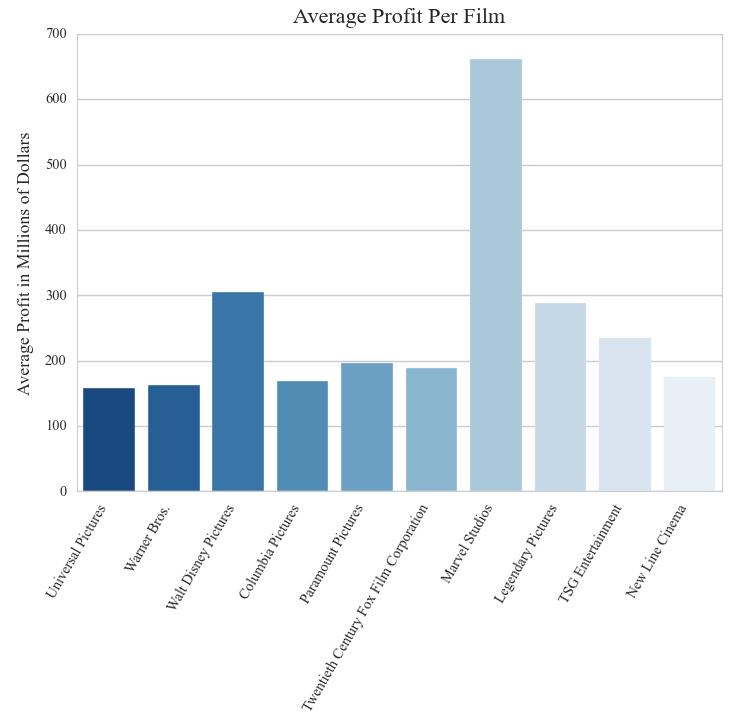

In [110]:
data2 = movies_by_production_companies.groupby('production_companies').mean().loc[data.index]['profit']

fig, ax = plt.subplots()

style.use('seaborn-talk')
style.use('seaborn-whitegrid')

sns.barplot(data2.index, data2, palette='Blues_r')
ax.set_title('Average Profit Per Film', fontname='Times New Roman', fontsize=20, pad=10)
ax.set_ylabel(ylabel='Average Profit in Millions of Dollars', fontsize=16, fontname='Times New Roman',labelpad=10)
ax.set_xlabel(xlabel='', fontsize=16, fontname='Times New Roman')
ax.set_xticklabels(centered_labels, fontname='Times New Roman')

# fix y-ticklabels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x/1000000) for x in current_values], fontname='Times New Roman')

plt.xticks(rotation=60, ha='right')

fig.savefig('top-production-companies-avg-profit.png', bbox_inches='tight');

In [109]:
# for "top" production companies, get avg profit & gross BY YEAR
query = ''' WITH large_production_companies AS (
                                                SELECT production_companies
                                                FROM movies_by_production_companies
                                                GROUP BY production_companies
                                                HAVING SUM(percentage_of_revenue) >= 0.01
                                                )
            SELECT production_companies, start_year, AVG(profit) AS avg_profit, SUM(worldwide_gross) AS gross_per_year
            FROM movies_by_production_companies
            WHERE production_companies IN large_production_companies
            GROUP BY production_companies, start_year
            ;
            '''

pc_over_time = psdf(query)

In [112]:
# option to expand into new column for data ...
pc_over_time['gross_per_year'].loc[ pc_over_time['production_companies'] == 'Illumination Entertainment' ].cumsum()

20    5.434646e+08
21    7.321222e+08
22    1.707339e+09
23    2.867675e+09
24    3.754426e+09
Name: gross_per_year, dtype: float64

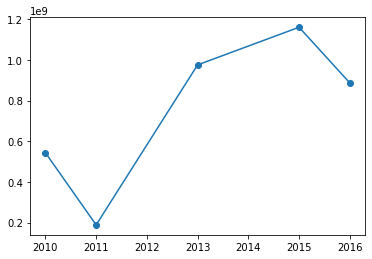

In [110]:
# plot gross per year as a line plot with respect to time
data = pc_over_time.loc[ pc_over_time['production_companies'] == 'Illumination Entertainment' ]

fig, ax = plt.subplots()

ax.plot('start_year', 'gross_per_year', data=data, marker='o');

# End newly organized

### Playing with Barplot Styling

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


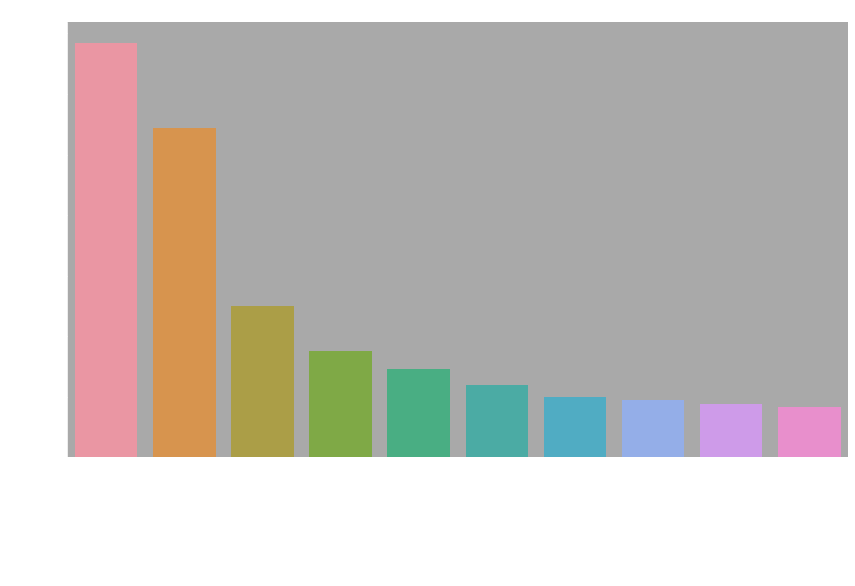

In [467]:
with plt.style.context('seaborn-pastel'):
    data = movies_w_genres.groupby('genres').sum()['worldwide_gross'].sort_values(ascending=False)[:10]

    centered_labels = [ word.center(26) for word in data.index ]

    centered_labels[9] = 'Comedy '

    fig, ax = plt.subplots(figsize=(14,8))

    bars = sns.barplot(centered_labels, data/1000000000)

    ax.set(title='Total Worldwide Gross by Genre', ylabel='Total Worldwide Gross in Billions ($)')

    ax.set_xticks(range(len(data)))
    
    plt.xticks(rotation=45, ha='right')
    
    # color plot background light grey
    ax.set_facecolor('#a9a9a9')
    
    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # color remaining spines
    ax.spines['left'].set_color('#fff')
    ax.spines['bottom'].set_color('#fff')
    
    # Make label colors for bars match bar colors
    list_of_colors = [patch.get_facecolor() for patch in bars.patches]
    n=0
    for t in ax.xaxis.get_ticklabels():
        t.set_color(list_of_colors[n])
        n+=1
    
    # Make color of tick lines match visible spines
    ax.tick_params(colors='#fff')
    
    # Make color of y-axis tick labels match visible spines
    [t.set_color('#fff') for t in ax.yaxis.get_ticklabels()]
    
    # Make color of y-axis label match visible spines
    ax.yaxis.label.set_color('#fff')
    
    # Make color of title match visible spines
    ax.title.set_color('#fff');

    # bbox = fig.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # width, height = bbox.width*fig.dpi, bbox.height*fig.dpi
    # height is 2/3 of width;

### Coloring individual bars, setting fontsize for ticklabels without passing new labels

In [ ]:
    data2 = movies_w_genres.groupby('genres').mean()['worldwide_gross'].sort_values(ascending=False)[:10]
    
    style.use('seaborn-talk')
    style.use('ggplot')

    fig, ax = plt.subplots(figsize=(12,8))

    bars = sns.barplot(data2.index, data2/1000000000)
    
#     bars[0].set_color('darkblue')

#     for n in [2,3,4]:
#         bars[n].set_color('darkblue')
    
#     for bar in bars:
#         if (bar == bars[0]) | (bar == bars[2]) | (bar == bars[3]) | (bar == bars[4]):
#             continue
#         else:
#             bar.set_color('lightblue')

    ax.set_xticks(range(len(data)))

    ax.set_title('Average Worldwide Gross by Genre', fontsize=20, fontname='Times New Roman')

    ax.set_ylabel('Average Gross per Film in Billions ($)', fontsize=16, fontname='Times New Roman', labelpad=10)

#     [t.set_fontsize(18) for t in ax.yaxis.get_ticklabels()]
    
#     [t.set_fontname('Times New Roman') for t in ax.yaxis.get_ticklabels()]

    ax.set_xticklabels(centered_labels,fontsize=16,fontname='Times New Roman')
    
#     plt.setp(ax.patches, linewidth=1)

    plt.xticks(rotation=45, ha='right')

    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False);

#     fig.savefig('genres2_barplt.png', bbox_inches='tight');

    # bbox = fig.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # width, height = bbox.width*fig.dpi, bbox.height*fig.dpi
    # height is 2/3 of width;

### Create the boxplot for the worldwide gross of films in the top genre in MILLIONS instead of billions

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


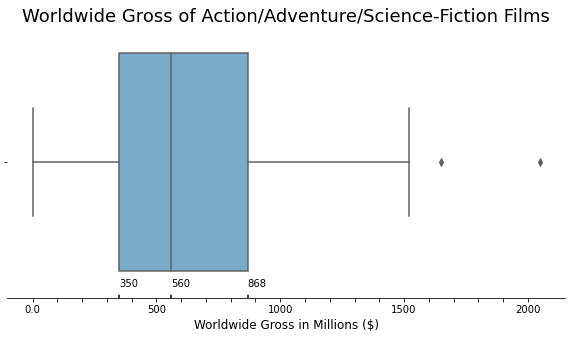

In [138]:
# Create the boxplot of top genre gross distribution in MILLIONS instead of billions

ww_gross_top_genre = movies_w_genres.loc[ movies_w_genres['genres'] == f'{data.index[0]}' ]['worldwide_gross']/1000000

fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(movies_w_genres.loc[ movies_w_genres['genres'] == f'{data.index[0]}' ]['worldwide_gross']/1000000, ax=ax,\
            palette = 'Blues_r')

ax.set_title('Worldwide Gross of Action/Adventure/Science-Fiction Films', fontsize=18, pad=5)
ax.set_xlabel('Worldwide Gross in Millions ($)', fontsize=12)

# add annotations to highlight quartiles
quart1 = int(ww_gross_top_genre.describe()['25%'])
ax.annotate(f'{round(quart1,0)}', xy=(quart1,0), xytext=(quart1-0.05,0.46), backgroundcolor='w')
quart3 = int(ww_gross_top_genre.describe()['75%'])
ax.annotate(f'{round(quart3,0)}', xy=(quart3,0), xytext=(quart3-0.05,0.46), backgroundcolor='w')
med = int(ww_gross_top_genre.describe()['50%'])
ax.annotate(f'{med}', xy=(med,0), xytext=(med-0.05,0.46), backgroundcolor='w')

# add dashed red vertical lines to highlight quartiles
ax.axvline(x=quart1, color='black', linestyle='--', ymin=-0.5, ymax=0.05)
ax.axvline(x=quart3, color='k', linestyle='--', ymin=-0.5, ymax=0.05)
ax.axvline(x=med, color='k', linestyle='--', ymin=-0.5, ymax=0.05)

# make x-axis ticks and labels a little more granular
ax.set_xticks(np.linspace(0,2000,21))
ax.set_xticklabels([0.0, '', '', '', '', 500, '', '', '', '', 1000, '', '', '', '', 1500, '', '', '', '', 2000])

# don't show the axes spines
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False);

### Play around with making word clouds with keywords from films in the various quartile bands of the top genre

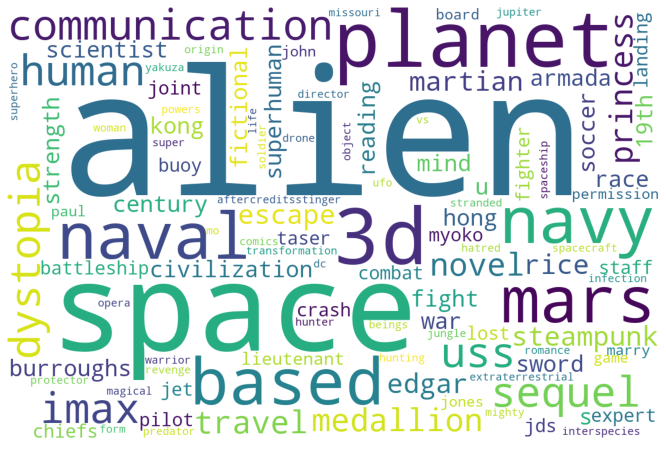

In [145]:
# Get keywords field in a usable format (string-ified json to list)

def to_list(value):
    if value == '[]':
        return None
    elif value is None:
        return None
    else:
        return [ pc_dict['name'] for pc_dict in json.loads(value) ]
    
movies_w_genres['keywords'] = movies_w_genres['keywords'].map(to_list)

# Make word cloud for bottom 25% of films in top genre

# Find index for each film in bottom 25% of worldwide gross

bottom_quarter_films = ww_gross_top_genre.loc[ ww_gross_top_genre < ww_gross_top_genre.describe()['25%'] ].index

# Loop through key words, and append each word to one long string

text_for_cloud = ''
for list_of_words in movies_w_genres.loc[bottom_quarter_films, 'keywords']:
    if list_of_words is None:
        continue
    else:
        for word in list_of_words:
            text_for_cloud = text_for_cloud + ' "' + word + '"'
            
# Generate word cloud with one long string

from wordcloud import WordCloud

cloud = WordCloud(width=1200, height=800, background_color='white').generate(text_for_cloud)

plt.figure(figsize=(12, 8)) # adjust figsize so that wordcloud can expand to given width & height

plt.imshow(cloud) # show the plot!

plt.axis('off') # don't show axis spines

plt.tick_params(length=0) # don't show tickmarks

# don't show tick labels
plt.xticks([])
plt.yticks([])

plt.savefig('bottom_quarter_wc.png', bbox_inches='tight');

# Repeat for each category (middle 50% of worldwide gross, and top 25% of worldwide gross)


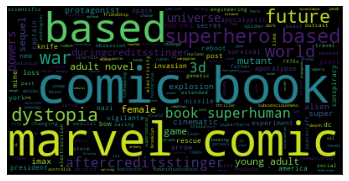

In [148]:
# Middle 50%

middle_half_films = ww_gross_top_genre.loc[ (ww_gross_top_genre > ww_gross_top_genre.describe()['25%'])\
                                          & (ww_gross_top_genre < ww_gross_top_genre.describe()['75%'])].index

text_for_cloud2 = ''
for list_of_words in movies_w_genres.loc[middle_half_films, 'keywords']:
    if list_of_words is None:
        continue
    else:
        for word in list_of_words:
            text_for_cloud2 = text_for_cloud2 + ' "' + word + '"'

cloud = WordCloud().generate(text_for_cloud2)
plt.imshow(cloud)
plt.tick_params(length=0)
plt.xticks([])
plt.yticks([])
plt.savefig('middle_half_wc.png', bbox_inches='tight');

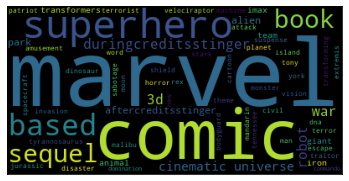

In [149]:
# Top 25%

top_quarter_films = ww_gross_top_genre.loc[ ww_gross_top_genre > ww_gross_top_genre.describe()['75%'] ].index

text_for_cloud3 = ''
for list_of_words in movies_w_genres.loc[top_quarter_films, 'keywords']:
    if list_of_words is None:
        continue
    else:
        for word in list_of_words:
            text_for_cloud3 = text_for_cloud3 + ' "' + word + '"'

cloud = WordCloud().generate(text_for_cloud3)
plt.imshow(cloud)
plt.tick_params(length=0)
plt.xticks([])
plt.yticks([])
plt.savefig('top_quarter_wc.png', bbox_inches='tight');